In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV

from tqdm import tqdm

import seaborn as sns

In [2]:
%matplotlib inline
plt.style.use('ggplot')

# Read and prepare Data first

In [3]:
# exported to read_dataset, will drop all MC features and stuff
from data_preparation import read_dataset
DATA, LABELS = read_dataset()

In [4]:
# store complete dataset and randomize entries for MRMR, can be turned on explicitly if
# data is not available
if False:
    full_df = pd.concat([LABELS, DATA], axis=1)
    filename = './data/full_dataset.csv'
    idxs = np.arange(len(full_df))
    np.random.shuffle(idxs)
    full_df.iloc[idxs].to_csv(filename, index=False)

In [7]:
# see http://penglab.janelia.org/proj/mRMR/#c++ for the implementation
# !cat data/mrmr_output.txt

# just get the results
mrmr_order, mrmr_feature_index, mrmr_feature_name, mrmr_score = np.genfromtxt('./data/mrmr_output.txt',
                                                                              unpack=True,
                                                                              skip_header=6,
                                                                              max_rows=50,)

In [6]:
mrmr_best_30 = DATA.columns[mrmr_feature_index[:30].astype(int)]

# Have a look at the data

100%|██████████| 125/125 [00:18<00:00,  7.02it/s]


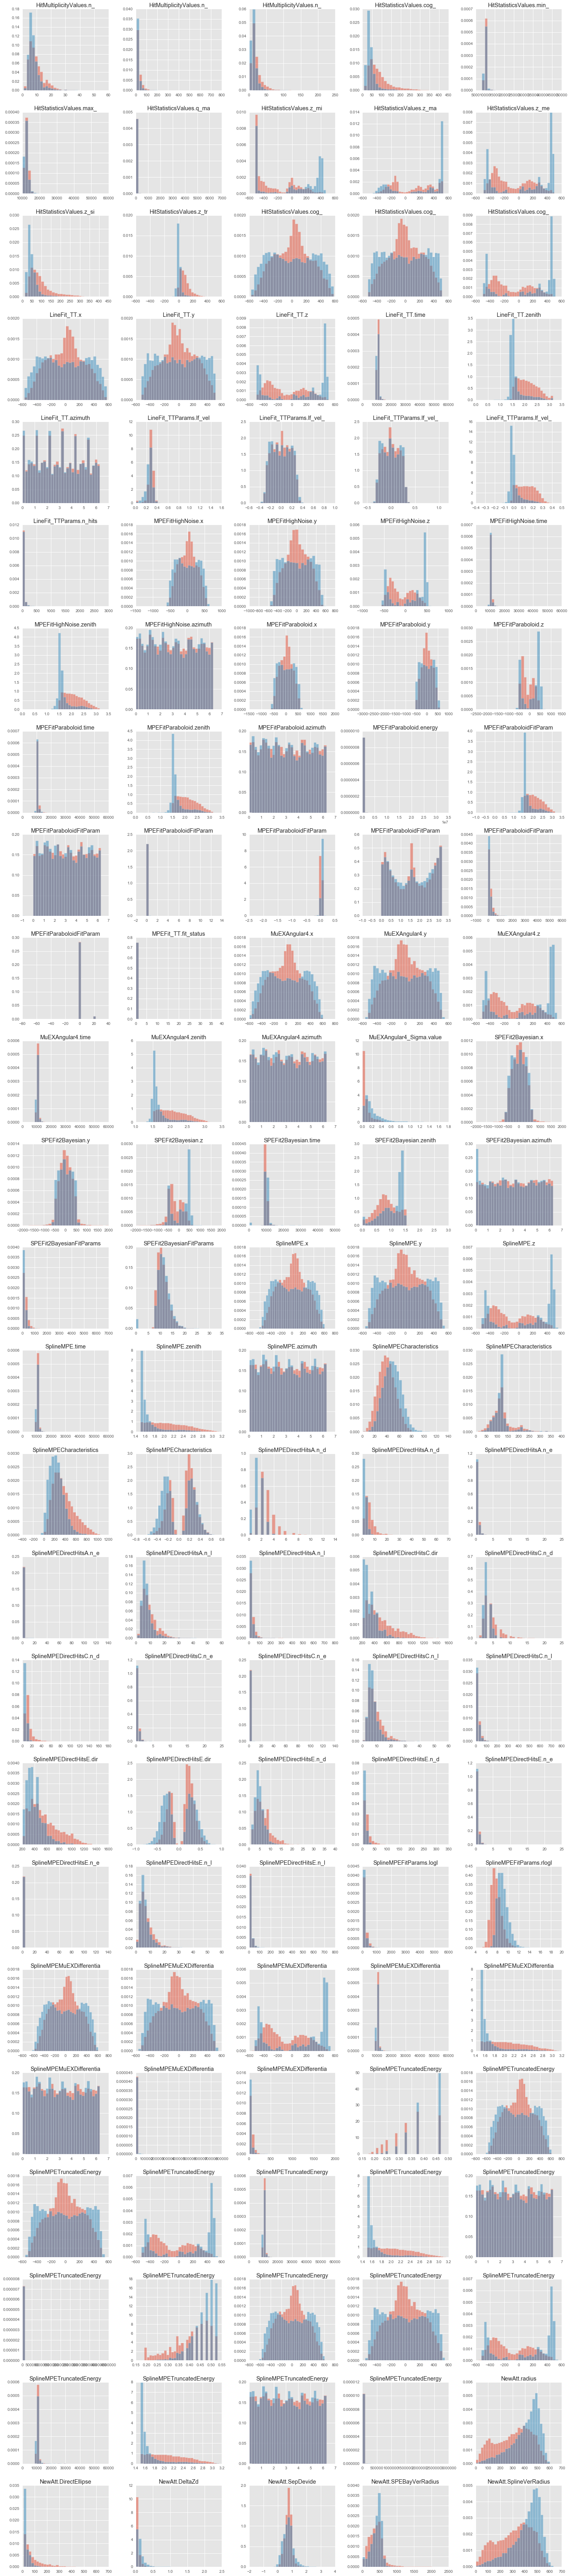

In [8]:
# Plot features, we have 157 of them this will probably take a while
plt.figure(figsize=(20, 90))
for i, feature in tqdm(enumerate(DATA.columns), total=len(DATA.columns)):
    plt.subplot(np.ceil(len(DATA.columns) / 5), 5, i+1)
    _, bins = np.histogram(DATA[feature], 30)
    plt.hist(DATA[LABELS==1][feature], bins=bins, alpha=0.5, normed=True)
    plt.hist(DATA[LABELS==0][feature], bins=bins, alpha=0.5, normed=True)
    plt.title(feature[:24])
plt.tight_layout()
plt.show()

# Lets run some classifiers
It turns out that GradientBoosting and RandomForest perform best under ROC AUC metric and with default parameters.
`classifier_comparison.py` runs a training for several different classifiers (no CV, no optimized parameters).

In [12]:
%run classifier_comparison.py

Reading Data.
Training/Loading several (4) classifiers now.
Found classifier object for RF
Found classifier object for GB
Found classifier object for KNN
Found classifier object for ADA
Compiling Network. Done.


In [22]:
gb = GradientBoostingClassifier()

In [23]:
train_data, test_data, train_labels, test_labels = train_test_split(DATA, LABELS, test_size=0.3)

In [21]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
    'max_depth': [2, 3, 4, 5, 6],
}

In [24]:
gb_grid_search = GridSearchCV(gb, param_grid, n_jobs=4, verbose=1)

In [25]:
gb_grid_search.fit(train_data, train_labels)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 12.7min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed: 20.7min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'max_depth': [2, 3, 4, 5, 6], 'learning_rate': [0.01, 0.05, 0.1, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [29]:
gb_grid_search.grid_scores_

[mean: 0.90029, std: 0.00426, params: {'max_depth': 2, 'learning_rate': 0.01},
 mean: 0.92925, std: 0.00369, params: {'max_depth': 3, 'learning_rate': 0.01},
 mean: 0.94207, std: 0.00224, params: {'max_depth': 4, 'learning_rate': 0.01},
 mean: 0.94961, std: 0.00128, params: {'max_depth': 5, 'learning_rate': 0.01},
 mean: 0.95246, std: 0.00172, params: {'max_depth': 6, 'learning_rate': 0.01},
 mean: 0.94864, std: 0.00238, params: {'max_depth': 2, 'learning_rate': 0.05},
 mean: 0.95921, std: 0.00091, params: {'max_depth': 3, 'learning_rate': 0.05},
 mean: 0.96429, std: 0.00031, params: {'max_depth': 4, 'learning_rate': 0.05},
 mean: 0.96593, std: 0.00132, params: {'max_depth': 5, 'learning_rate': 0.05},
 mean: 0.96696, std: 0.00142, params: {'max_depth': 6, 'learning_rate': 0.05},
 mean: 0.96129, std: 0.00043, params: {'max_depth': 2, 'learning_rate': 0.1},
 mean: 0.96625, std: 0.00072, params: {'max_depth': 3, 'learning_rate': 0.1},
 mean: 0.96882, std: 0.00141, params: {'max_depth': 4,

In [28]:
proba = gb_grid_search.best_estimator_.predict_proba(test_data)[:,1]
score = roc_auc_score(test_labels, proba)
score

0.99440261048917877

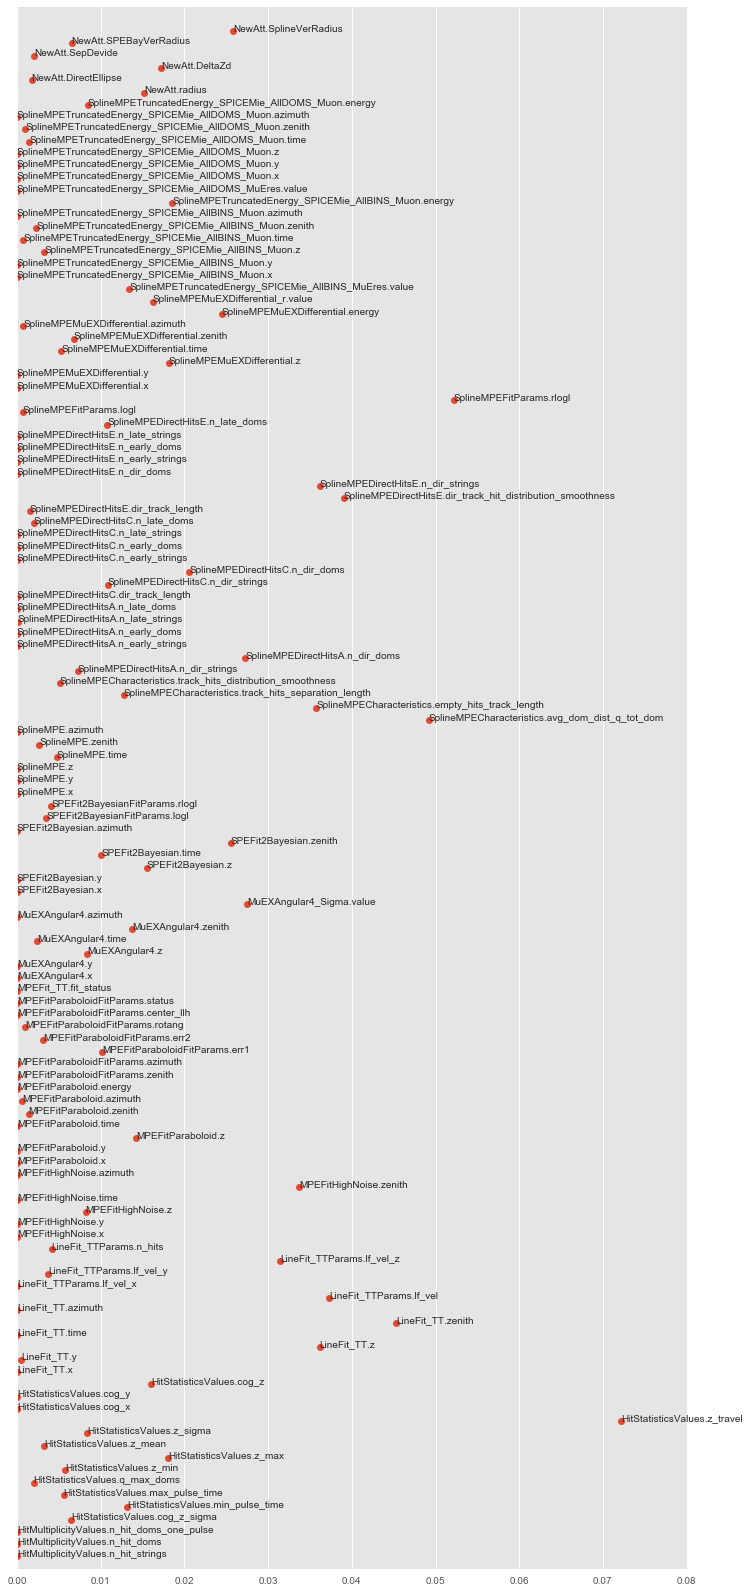

In [11]:
plt.figure(figsize=(12,28))
fis = gb.feature_importances_
plt.plot(fis, range(len(DATA.columns)), 'o')
for i, f in enumerate(DATA.columns):
    plt.annotate(f, (fis[i], i))
plt.yticks([])
plt.ylim(-1, len(DATA.columns) + 1)
plt.show()